In [1]:
import gc
from desom.som_layer import SOMLayer
from desom.autoencoder import conv2d_autoencoder
from desom.datasets import load_data

import tensorflow as tf
from keras.models import Model, Sequential
from keras.metrics import Mean, MeanAbsoluteError

import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import xarray as xr
import multiprocessing

%load_ext autoreload
%autoreload 2

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
from plots import *
from Experiment import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
exp_wind = ClusteringExperiment(
    'ERA5', 'Wind', '300', None, None, -60, 60, 25, 85, 
    'anomaly', 'JJA', 'none', None, 
    {'detrended': False, 'time': ('win', 15)}, inner_norm=None
)
da = exp_wind.open_da('anomaly', season='JJA')
X = da.values[:, :, :, None]
meanX, varX = np.mean(X), np.var(X)

In [102]:
da = xr.open_dataarray('../s_anom.nc')
X = da.values[:, :, :, None]
meanX, varX = np.mean(X), np.var(X)
map_size = (8, 8)
latent_dim = 32
input_shape = X.shape[1:]
input_shape = (input_shape[1], input_shape[0], input_shape[2])
save_dir = 'results/tmp'
epochs = 5
batch_size = 32
save_file_ae = Path(f'{save_dir}/ae_weights-epoch{epochs}.h5')

In [4]:
if not save_file_ae.is_file():
    def do_fit(X, epochs, batch_size, verbose):
        autoencoder, _, _ = conv2d_autoencoder(input_shape, latent_dim, [32, 32, 64, 64], 5, 2, 'stretch', meanX, varX)
        autoencoder.compile('adam', 'mse')
        autoencoder.fit(X, X, epochs=epochs, batch_size=batch_size, verbose=verbose)
        autoencoder.save_weights(save_file_ae)
    process_eval = multiprocessing.Process(target=do_fit, args=(X, epochs, batch_size, 1))
    process_eval.start()
    process_eval.join()

In [105]:
indices = np.random.randint(len(X), size=5)
theseX = X[indices]

autoencoder, encoder, decoder = conv2d_autoencoder(input_shape, latent_dim, [32, 32, 64, 64], 5, 2, 'stretch', meanX, varX)
# autoencoder.load_weights(save_file_ae)
# theseXp = autoencoder.predict(theseX)
# onecoord = {key: da.coords[key].values for key in ['lat', 'lon']}
# allX = [xr.DataArray(thisX[:, :, 0], coords=onecoord) for thisX in np.concatenate([theseX, theseXp], axis=0)]
# clu = Clusterplot(2, 5, (-60, 60, 25, 85))
# for x, ax in zip(allX, clu.axes):
#     ax.imshow(x, cmap='Purples', origin='lower', extent=(-60, 60, 25, 85))
#     ax.axis('off')

In [103]:
images = decoder.predict(np.eye(latent_dim)[:, :, None])
onecoord = {key: da.coords[key].values for key in ['lat', 'lon']}
images_as_da = [xr.DataArray(image[:, :, 0], coords=onecoord) for image in images]
vmin, vmax = np.amin(images), np.amax(images)
clu = Clusterplot(5, latent_dim // 5, exp_wind.get_region(), honeycomb=False)
for im, ax in zip(images, clu.axes):
    hehe = ax.imshow(im, cmap='Purples', origin='lower', extent=exp_wind.get_region())
    ax.axis('off')
plt.colorbar(hehe, ax=clu.axes)

2023-06-27 12:06:13.601837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 446ms/step


ValueError: conflicting sizes for dimension 'lon': length 1 on the data but length 241 on coordinate 'lon'

In [5]:
som_layer = SOMLayer(map_size, name='som', loss_factor=1)(encoder.output)
model = Model(
    inputs=autoencoder.input, outputs=[autoencoder.output, som_layer]
)
for layer in model.layers:
    layer.trainable = True
model.compile(
    loss={'denormalize_output': "mse", "som": 'mse'},
    loss_weights=[5., 0.],
    optimizer='adam',
)

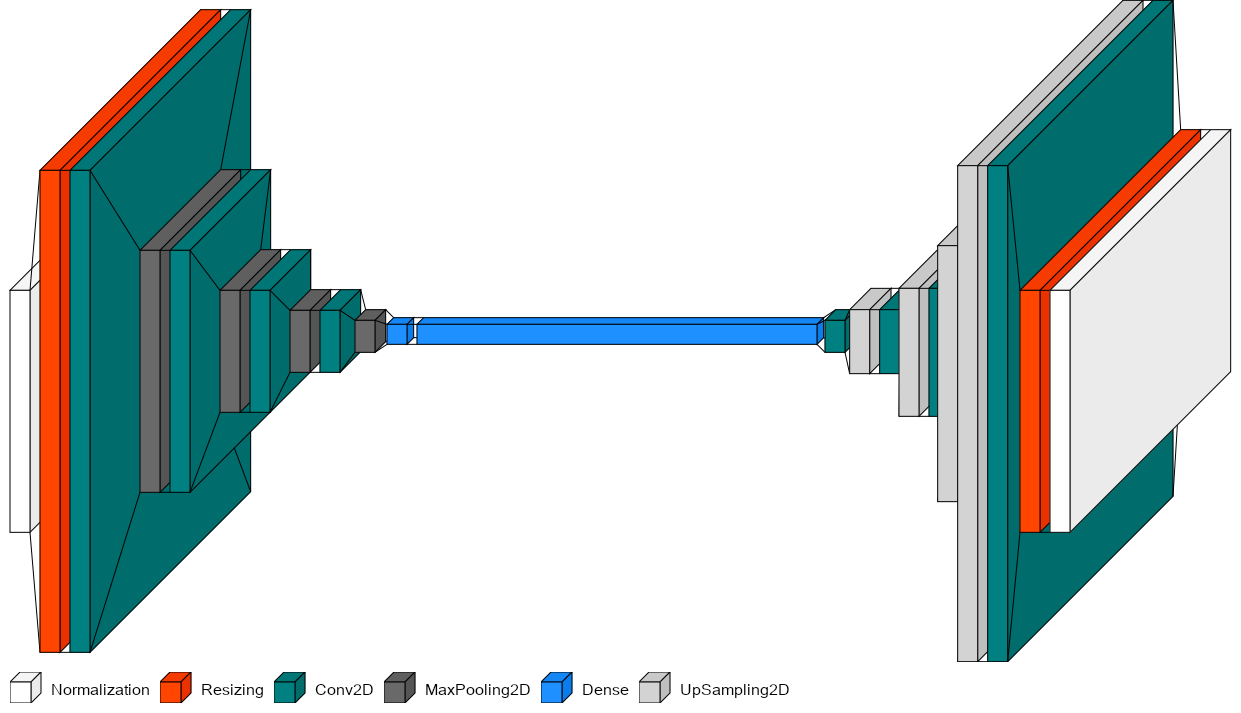

In [114]:
import visualkeras
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D, Resizing, InputLayer, Reshape, UpSampling2D, Normalization
from collections import defaultdict
from PIL import ImageFont

font = ImageFont.truetype("/Library/Fonts/Arial Unicode.ttf", 16)  # using comic sans is strictly prohibited!

color_map = defaultdict(dict)
color_map[UpSampling2D]['fill'] = 'lightgray'
color_map[MaxPooling2D]['fill'] = 'dimgray'

color_map[Conv2D]['fill'] = 'teal'
color_map[Dense]['fill'] = 'dodgerblue'
# color_map[Flatten]['fill'] = 'teal'
# color_map[Reshape]['fill'] = 'teal'
color_map[Resizing]['fill'] = 'orangered'
color_map[Normalization]['fill'] = 'white'
color_map[InputLayer]['fill'] = 'white'


visualkeras.layered_view(autoencoder, legend=True, color_map=color_map, draw_volume=True, scale_xy=2, max_xy=3000, type_ignore=[Reshape, Flatten, InputLayer], font=font, to_file='../../Presentations/IUGG/Figures/desom_plot.png')


In [8]:
epochs = 10
batch_size = 32
save_file = Path(f'{save_dir}/desom_weights-epoch{epochs}.h5')
Y_s = np.zeros(len(X))
model.fit(X, [X, Y_s], epochs=epochs, batch_size=batch_size, verbose=1)
model.save_weights(save_file)


Epoch 1/10


2023-06-16 16:10:53.018733: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f4f70ddf610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-16 16:10:53.018786: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-06-16 16:10:53.025099: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-16 16:10:53.314718: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


182/182 [==============================] - 23s 80ms/step - loss: 21.1266 - denormalize_output_loss: 3.5574 - som_loss: 2.8600
Epoch 2/10
182/182 [==============================] - 14s 77ms/step - loss: 11.1507 - denormalize_output_loss: 2.0442 - som_loss: 0.2677
Epoch 3/10
182/182 [==============================] - 14s 77ms/step - loss: 9.2673 - denormalize_output_loss: 1.7201 - som_loss: 0.1614
Epoch 4/10
182/182 [==============================] - 14s 77ms/step - loss: 8.2905 - denormalize_output_loss: 1.5477 - som_loss: 0.1116
Epoch 5/10
182/182 [==============================] - 14s 77ms/step - loss: 7.7473 - denormalize_output_loss: 1.4469 - som_loss: 0.0854
Epoch 6/10
182/182 [==============================] - 14s 77ms/step - loss: 6.7076 - denormalize_output_loss: 1.2548 - som_loss: 0.0575
Epoch 7/10
182/182 [==============================] - 14s 77ms/step - loss: 6.4126 - denormalize_output_loss: 1.2026 - som_loss: 0.0412
Epoch 8/10
182/182 [==============================] - 14s

2/2 [==============================] - 0s 16ms/step


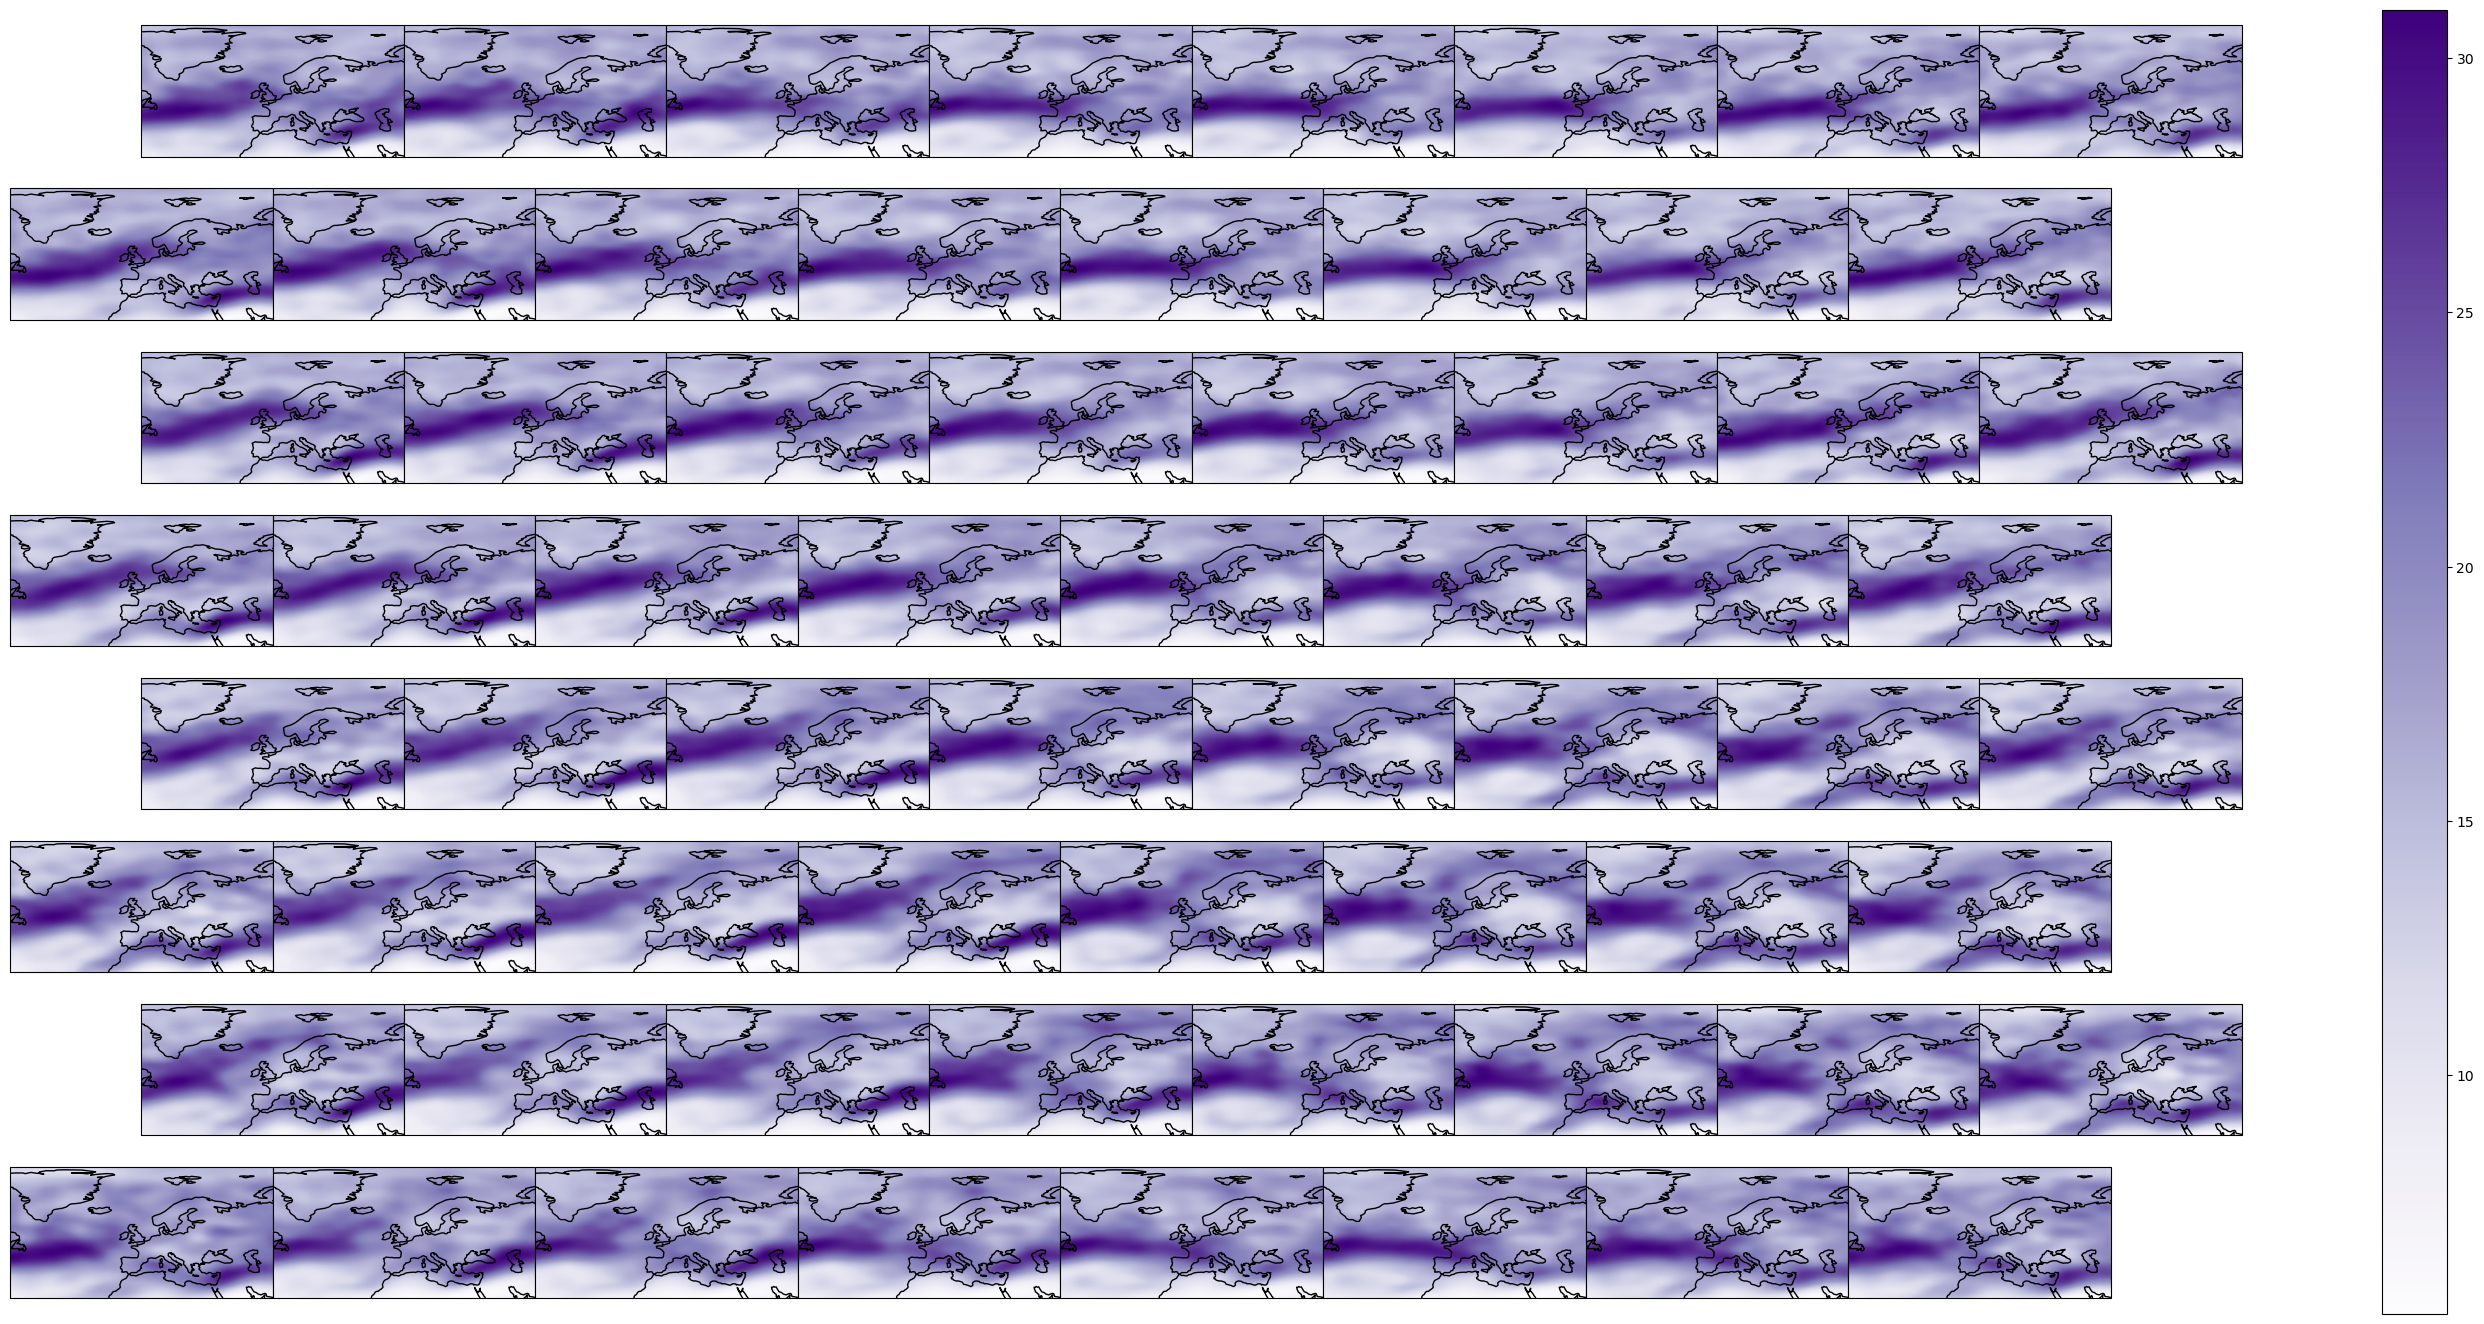

In [9]:
images = decoder.predict(model.get_layer(name='som').get_weights()[0][:, :, None])
images_as_da = [xr.DataArray(image[:, :, 0], coords=onecoord) for image in images]
vmin, vmax = np.amin(images), np.amax(images)
clu = Clusterplot(*map_size, exp_wind.get_region(), honeycomb=True)
for im, ax in zip(images, clu.axes):
    hehe = ax.imshow(im, cmap='Purples', origin='lower', extent=exp_wind.get_region())
plt.colorbar(hehe, ax=clu.axes)

In [10]:
from keras.layers import Lambda
argmax_layer = Lambda(lambda x: tf.argmin(x, axis=1), name='y_pred')(som_layer)
classifier = Model(inputs=encoder.input, outputs=argmax_layer)
labels = classifier.predict(X)

182/182 [==============================] - 1s 7ms/step


In [13]:
unique_labels, counts = np.unique(labels, return_counts=True)
mask = labels_to_mask(labels)

In [17]:
exp_wind_rel = ClusteringExperiment(
    'ERA5', 'Wind', '300', None, None, *exp_wind.get_region(), 
    'anomaly', 'JJA', 'doy', {'dayofyear': ('win', 30)}, 
    {'detrended': False, 'time': ('win', 15)}, inner_norm=None
)
da_rel = exp_wind_rel.open_da('anomaly', season='JJA')
exp_T = ClusteringExperiment(
    'ERA5', 'Temperature', '2m', 'box_-25_60_32_72', 't', 
    None, None, None, None, 'anomaly', 'JJA', 'doy', 
    {'dayofyear': ('win', 30)}, 
    {'detrended': False, 'time': ('fft', 10)}, 
    inner_norm=None
)
da_T = exp_T.open_da('anom', 'JJA')

In [19]:
np.sum(mask, axis=0)

array([ 43,  69,  34, 100,  80, 111,  84,  72, 108,  68, 118,  59,  97,
       118,  84, 128,  58,  73,  86,  98, 121, 109,  93, 121,  78,  75,
       112,  99, 122, 125, 132,  82, 113,  97, 101, 114, 126, 146, 158,
       134,  62,  40,  83,  62,  79,  66, 122, 109,  62,  67,  92,  73,
        55,  76, 111,  47,  86,  87,  67,  82, 101,  65,  63,  93])

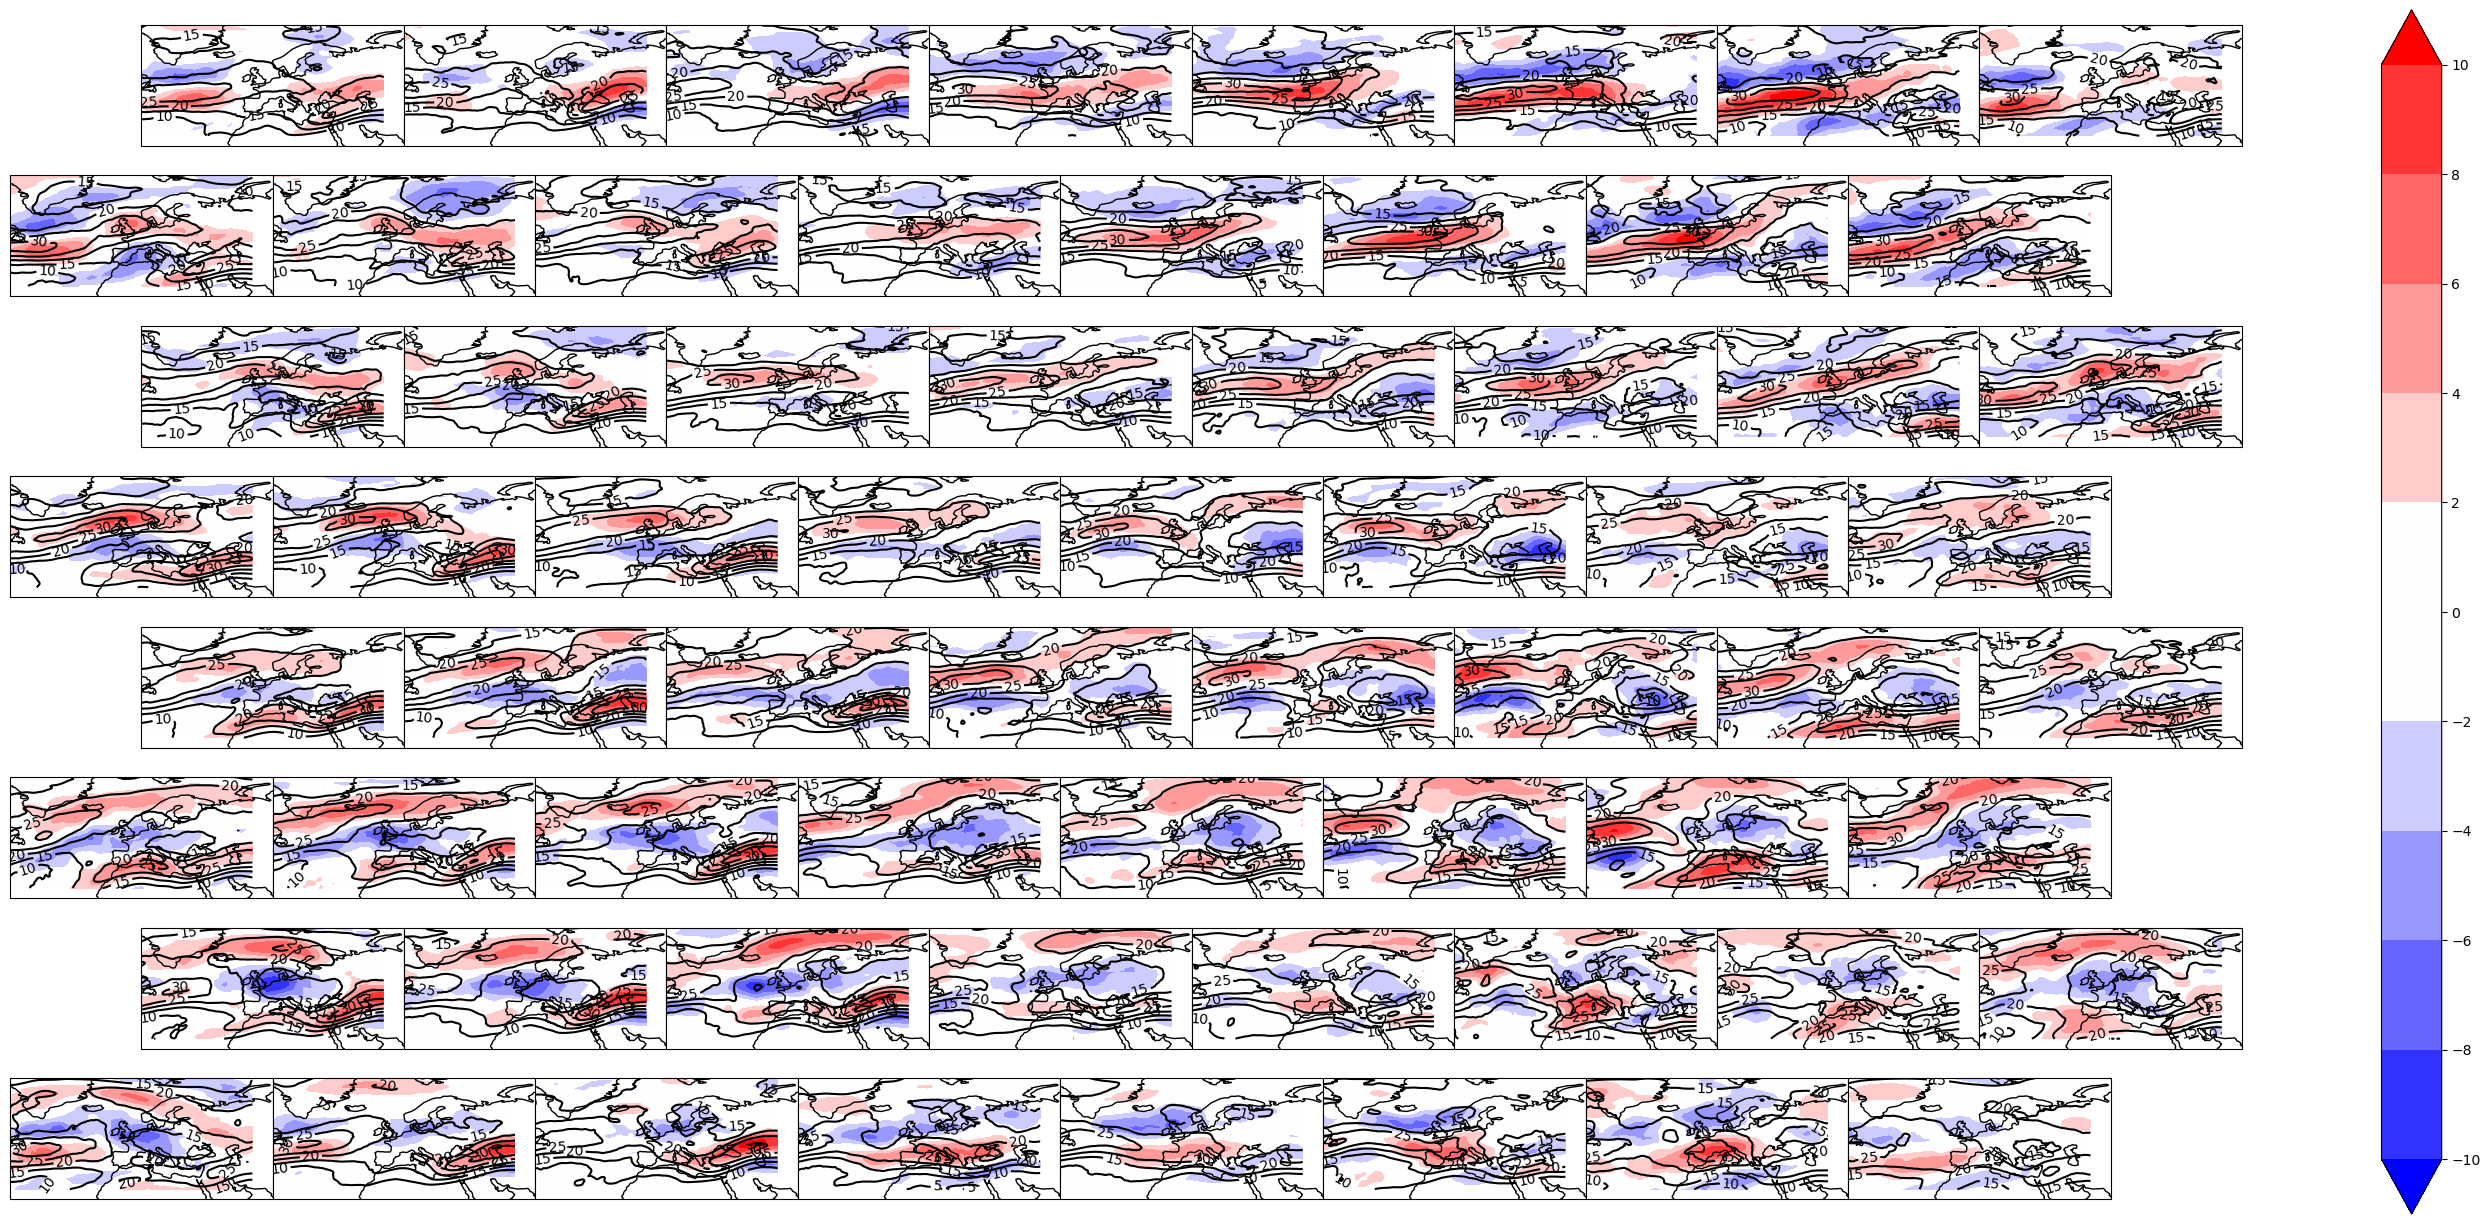

In [18]:
clu = Clusterplot(*map_size, honeycomb=True)
clu.add_any_contour_from_mask(da, mask, 'contour', clabels=True)
clu.add_any_contour_from_mask(da_rel, mask, 'contourf')

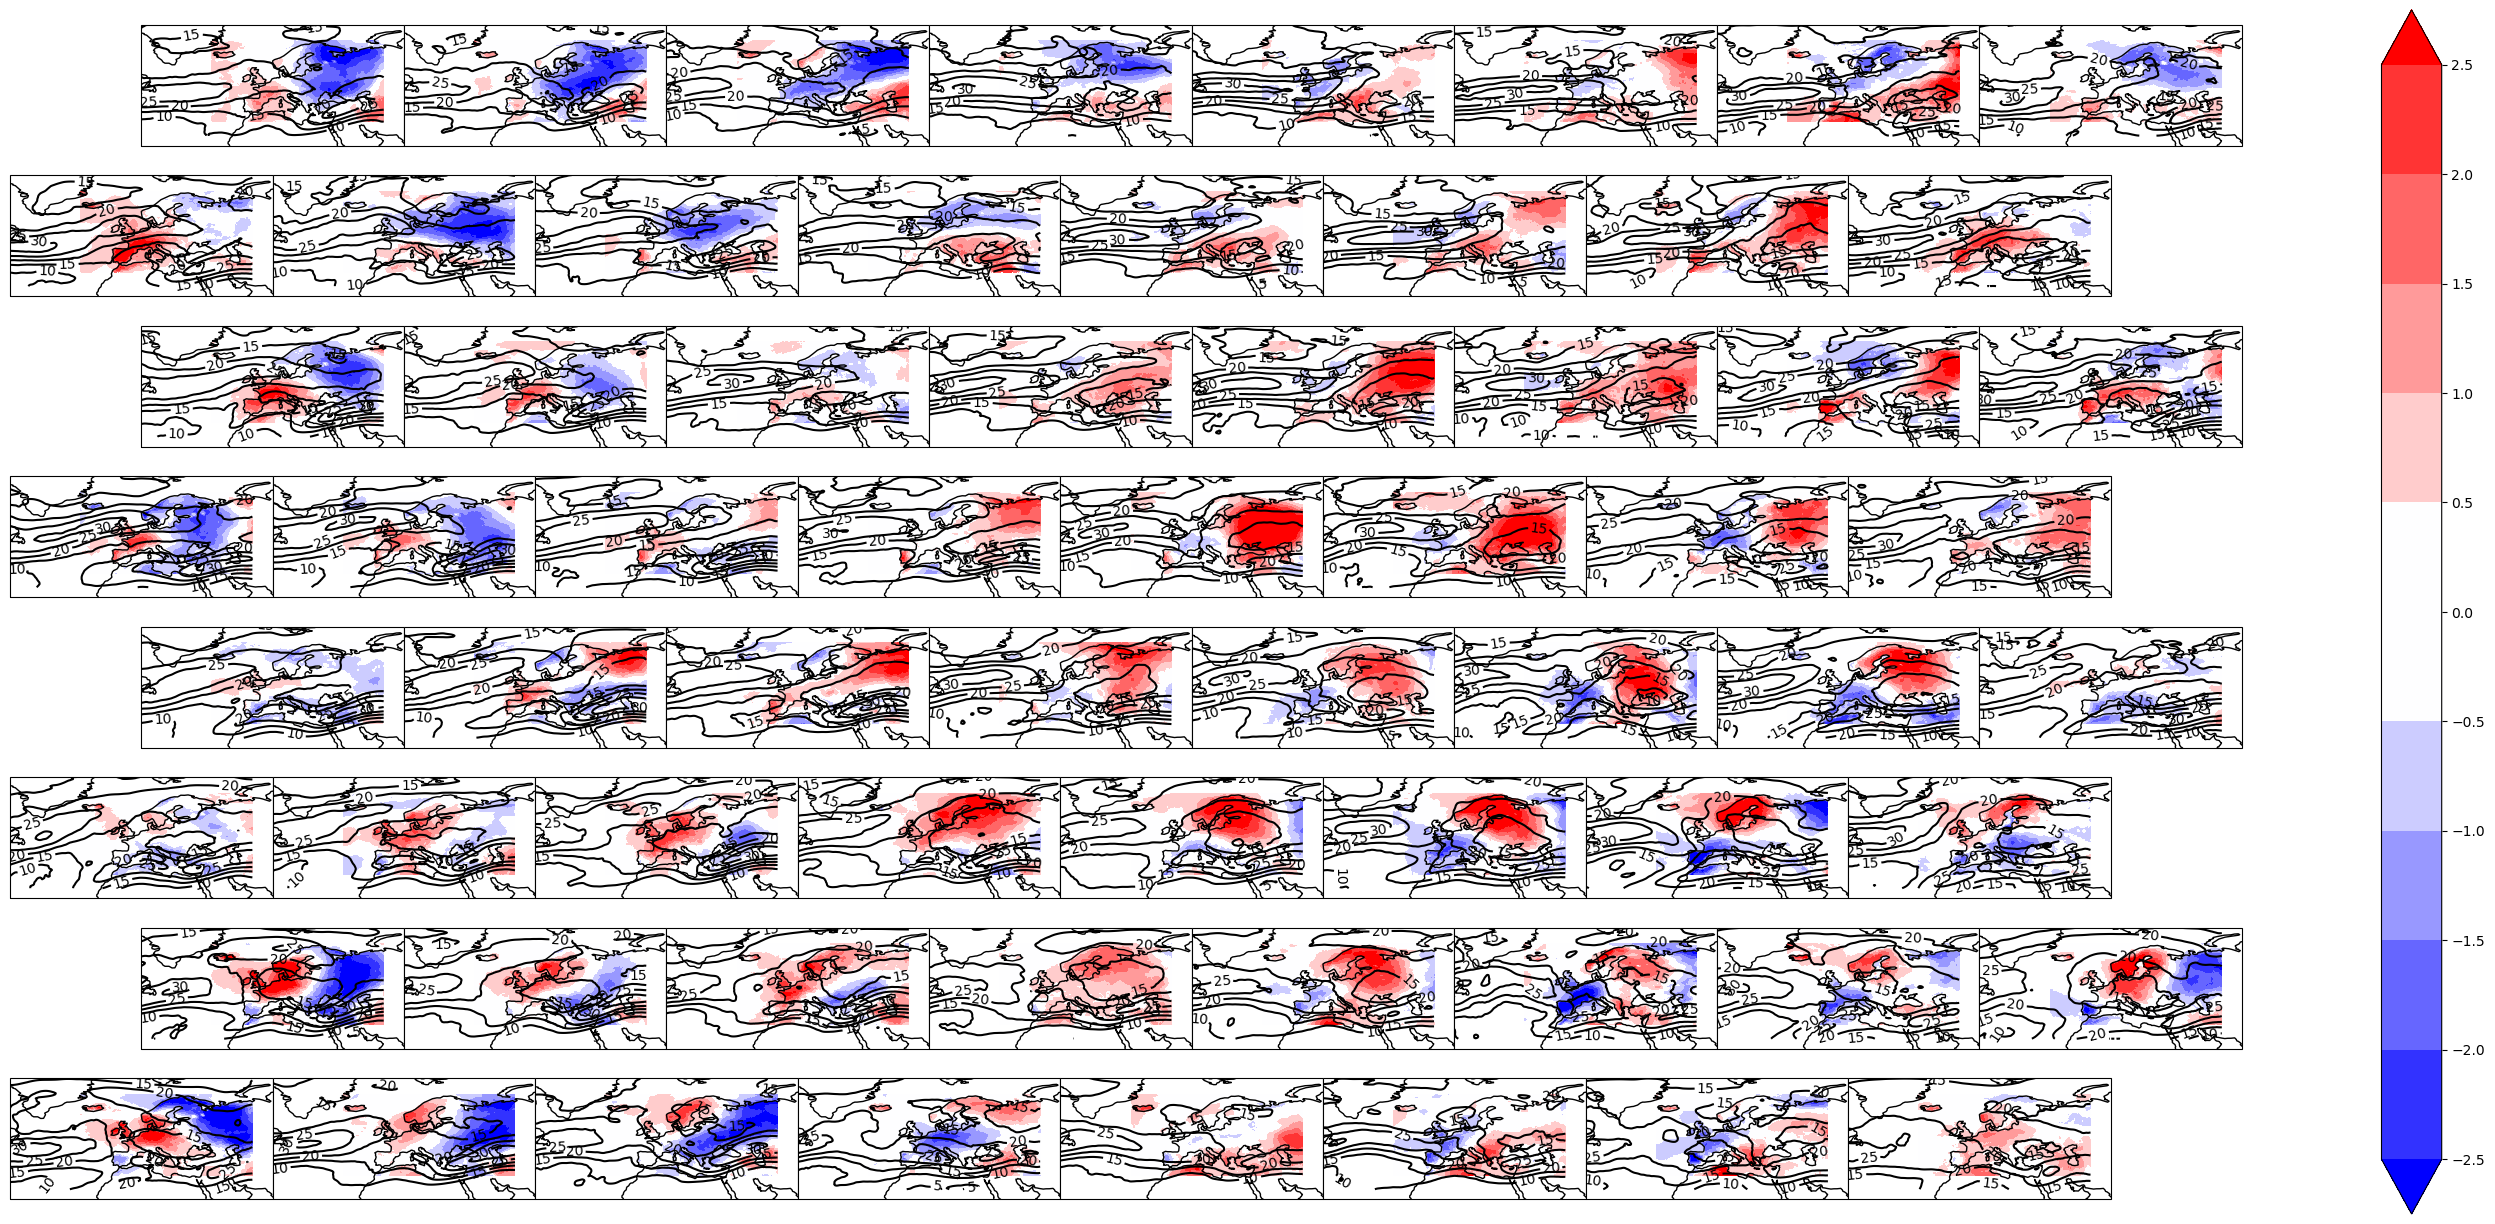

In [15]:
clu = Clusterplot(*map_size, honeycomb=True)
clu.add_any_contour_from_mask(da, mask, 'contour', clabels=True)
clu.add_any_contour_from_mask(da_T, mask, 'contourf')

In [ ]:
from keras.layers import Input
def zeroloss(ypred, ytrue):
    return 0.
(X, Y), (X_val, Y_val) = load_data('mnist', flatten=True)
map_size = (8, 8)

x = Input(shape=(X.shape[1],), name='input')
som = SOMLayer(map_size, name='som')(x)
onlysom = Model(inputs=x, outputs=som)
onlysom.compile(optimizer='adam')
onlysom.fit(X, batch_size=256, epochs=5)

In [ ]:
images = onlysom.get_layer(name='som').get_weights()[0]
fig, axes = plt.subplots(*map_size, figsize=(15, 15))
for im, ax in zip(images, axes.flatten(order='F')):
    ax.imshow(im.reshape((28, 28)), cmap='gray')
    ax.axis('off')